# Previsão de Produção de Petróleo utilizando Aprendizado de Máquina
Mateus de Araujo Fernandes

# Inicialização

### Conexão ao Drive e Importação de Bibliotecas

In [1]:
import datetime
import math
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
%pylab inline
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor

import warnings
warnings.filterwarnings('ignore')

#import os
#os.listdir()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\Users\bevq\OneDrive - PETROBRAS\Documents\Data_Science_Res\ambiente_virtual_doc\Lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### Definição da Função SMAPE

In [2]:
# Opção mais simples, que não funciona com array

def smape_calc(a, f):
    #return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f)))

def mape_calc(a, f):
    return 1/len(a) * np.sum(np.abs(f-a)/np.abs(f))

### Definição da Função de Carregamento das Curvas

In [3]:
#Lista de arquivos para composição do banco de dados
arquivos = ['Unisim_Final.rwo'] #['Unisim_H.rwo', 'Unisim_I.rwo','Unisim_C.rwo','Unisim_D.rwo','Unisim_E.rwo','Unisim_F.rwo','Unisim_G.rwo','Unisim_A.rwo','Unisim_C.rwo','Unisim_J.rwo']

dataset_lido = pd.read_csv(filepath_or_buffer = 'Unisim_Final.rwo', sep = '\t', skiprows=2, header=[0,1,2,3])
dataset_lido = dataset_lido.drop(columns=['TIME'])
dataset_lido = dataset_lido.set_index('DATE')
#Remove colunas de dados por grupo e pressões para fazer previsão por poço
#cols = [0,1,2,3,4,11,18,25,26,27,28,29,30,31,32,40]
cols = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40] # Tira as curvas por poço
dataset_lido = dataset_lido.drop(dataset_lido.columns[cols],axis=1)


def gera_dataset (dataset_lido, look_back_f, look_forward_f, amostragem):
    #Função para ler gerar dataset para algoritmo de aprendizado
    array_df=[]
    df=[]
    #Amostrando conforme definição na chamada e eliminando o período de ramp up para evitar treinamento com num. poços diferente
    temp_df = dataset_lido[1250:8000:amostragem]
    #Rotina para criação de datasets para Rede MLP
    seq_1, seq_2 = [], []
    for i in range(len(temp_df)):
      # definição dos limites da janela
	    end_ix = i + look_back_f
	    out_end_ix = end_ix + look_forward_f
	    # interrompe no tamanho do histórico
	    if out_end_ix > len(temp_df):
		    break
      # agrega dos dados para formar o conjunto de entradas e saídas
	    for j in range(i, end_ix):
		    seq_1.extend(temp_df.values[j,:])
	    for k in range(end_ix, out_end_ix):
		    seq_1.extend(temp_df.values[k,0:3])
	    seq_2.append(seq_1)
	    seq_1 = []
    array_df.append(seq_2)

    df = pd.DataFrame(array_df[0])
    #for y in range(1,len(arquivos_f)):
    #df_aux = pd.DataFrame(array_df[y])
    #df = pd.concat([df, df_aux], axis=0)

    return df

### Parâmetros para Grid Search

In [6]:
look_back = [5, 10, 15, 20, 25, 30, 40]
look_forward = 1
amostragem = [5, 10, 15, 20, 25, 30]
estimator = ["nn", "lr", "rr"]
nn_hidden_layer = [5, 10, 15, 20, 40, 70, 100]
nn_activation = ["identity"]#, "relu", "tanh"]
ridge_alpha = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0]
training_window = []
contador = 0
log_grid_search = []
n_prod = 1
n_inj = 2

for look_back_loop in look_back:
    for amostragem_loop in amostragem:
        if amostragem_loop*look_back_loop > 400: break
        if amostragem_loop*look_back_loop < 50: break
        for estimator_loop in estimator:
            
            if estimator_loop == "lr":
                #print("regressão linear")
                data = gera_dataset(dataset_lido, look_back_loop, look_forward, amostragem_loop)

                n = len(data)
                position = int(n*0.72)  
                train_df = data[int(n*0.2):position]
                test_df = data[position+look_forward:int(n*0.85)]

                num_entradas = ((n_prod*3)+n_inj)*look_back_loop
                num_saidas = n_prod*3*look_forward #Adaptar aqui para usar passos maiores e saidas multiplas
                x_train = train_df.iloc[:, 0:num_entradas]
                y_train = train_df.iloc[:, num_entradas:num_entradas+num_saidas]
                #x_val = val_df.iloc[:, 0:num_entradas]
                #y_val = val_df.iloc[:, num_entradas:num_entradas+num_saidas]
                x_test = test_df.iloc[:, 0:num_entradas]
                y_test = test_df.iloc[:, num_entradas:num_entradas+num_saidas]
                
                preprocessParams = preprocessing.StandardScaler().fit(x_train)
                preprocessParams_y = preprocessing.StandardScaler().fit(y_train)

                x_train_normalized = preprocessParams.transform(x_train)
                #x_val_normalized = preprocessParams.transform(x_val)
                x_test_normalized = preprocessParams.transform(x_test)
                x_train_normalized = pd.DataFrame(x_train_normalized, columns = x_train.columns.values)
                #x_val_normalized = pd.DataFrame(x_val_normalized, columns = x_val.columns.values)
                x_test_normalized = pd.DataFrame(x_test_normalized, columns = x_test.columns.values)
                y_train_normalized = preprocessParams_y.transform(y_train)
                #y_val_normalized = preprocessParams_y.transform(y_val)
                y_test_normalized = preprocessParams_y.transform(y_test)
                y_train_normalized = pd.DataFrame(y_train_normalized, columns = y_train.columns.values)
                #y_val_normalized = pd.DataFrame(y_val_normalized, columns = y_val.columns.values)
                y_test_normalized = pd.DataFrame(y_test_normalized, columns = y_test.columns.values)    

                regressor = LinearRegression()
                regressor.fit(x_train_normalized, y_train_normalized)
                # Avaliação do treinamento
                score_train = regressor.score(x_train_normalized, y_train_normalized)
                previsoes = regressor.predict(x_test_normalized)
                previsoes_df = pd.DataFrame(previsoes)
                mae = mean_absolute_error(y_test_normalized, previsoes)
                mse = mean_squared_error(y_test_normalized, previsoes)
                smape_vector = []
                mape_vector = []
                for i_smape in range(0, 3*n_prod):
                    qo_test = y_test_normalized.iloc[:,i_smape]
                    qo_pred_test = previsoes_df.iloc[:,i_smape]
                    smape_vector.append(smape_calc(qo_test, qo_pred_test))
                    mape_vector.append(mape_calc(qo_test, qo_pred_test))
                smape = mean(smape_vector) 
                mape = mean(mape_vector)

                log_grid_search.append([look_back_loop, amostragem_loop, estimator_loop, 0, 0, score_train, score_test, mae, mse, smape, mape])

                contador = contador + 1
            
            if estimator_loop == "rr":
                for ridge_alpha_loop in ridge_alpha:

                    data = gera_dataset(dataset_lido, look_back_loop, look_forward, amostragem_loop)

                    n = len(data)
                    position = int(n*0.72)  
                    train_df = data[int(n*0.2):position]
                    test_df = data[position+look_forward:int(n*0.85)]

                    num_entradas = ((n_prod*3)+n_inj)*look_back_loop
                    num_saidas = n_prod*3*look_forward #Adaptar aqui para usar passos maiores e saidas multiplas
                    x_train = train_df.iloc[:, 0:num_entradas]
                    y_train = train_df.iloc[:, num_entradas:num_entradas+num_saidas]
                    #x_val = val_df.iloc[:, 0:num_entradas]
                    #y_val = val_df.iloc[:, num_entradas:num_entradas+num_saidas]
                    x_test = test_df.iloc[:, 0:num_entradas]
                    y_test = test_df.iloc[:, num_entradas:num_entradas+num_saidas]
                
                    preprocessParams = preprocessing.StandardScaler().fit(x_train)
                    preprocessParams_y = preprocessing.StandardScaler().fit(y_train)

                    x_train_normalized = preprocessParams.transform(x_train)
                    #x_val_normalized = preprocessParams.transform(x_val)
                    x_test_normalized = preprocessParams.transform(x_test)
                    x_train_normalized = pd.DataFrame(x_train_normalized, columns = x_train.columns.values)
                    #x_val_normalized = pd.DataFrame(x_val_normalized, columns = x_val.columns.values)
                    x_test_normalized = pd.DataFrame(x_test_normalized, columns = x_test.columns.values)
                    y_train_normalized = preprocessParams_y.transform(y_train)
                    #y_val_normalized = preprocessParams_y.transform(y_val)
                    y_test_normalized = preprocessParams_y.transform(y_test)
                    y_train_normalized = pd.DataFrame(y_train_normalized, columns = y_train.columns.values)
                    #y_val_normalized = pd.DataFrame(y_val_normalized, columns = y_val.columns.values)
                    y_test_normalized = pd.DataFrame(y_test_normalized, columns = y_test.columns.values)    

                    regressor = Ridge(alpha=ridge_alpha_loop, fit_intercept=True)
                    regressor.fit(x_train_normalized, y_train_normalized)
                    # Avaliação do treinamento
                    score_train = regressor.score(x_train_normalized, y_train_normalized)
                    previsoes = regressor.predict(x_test_normalized)
                    previsoes_df = pd.DataFrame(previsoes)
                    mae = mean_absolute_error(y_test_normalized, previsoes)
                    mse = mean_squared_error(y_test_normalized, previsoes)
                    score_test = regressor.score(x_test_normalized, y_test_normalized)
                    smape_vector = []
                    mape_vector = []
                    for i_smape in range(0, 3*n_prod):
                        qo_test = y_test_normalized.iloc[:,i_smape]
                        qo_pred_test = previsoes_df.iloc[:,i_smape]
                        smape_vector.append(smape_calc(qo_test, qo_pred_test))
                        mape_vector.append(mape_calc(qo_test, qo_pred_test))
                    smape = mean(smape_vector) 
                    mape = mean(mape_vector)

                    log_grid_search.append([look_back_loop, amostragem_loop, estimator_loop, ridge_alpha_loop, 0, score_train, score_test, mae, mse, smape, mape])

                    contador = contador + 1
            
            if estimator_loop == "nn":
                for nn_activation_loop in nn_activation:
                    for nn_hidden_layer_loop in nn_hidden_layer:
                        data = gera_dataset(dataset_lido, look_back_loop, look_forward, amostragem_loop)

                        n = len(data)
                        position = int(n*0.72)  
                        train_df = data[int(n*0.2):position]
                        test_df = data[position+look_forward:int(n*0.85)]

                        num_entradas = ((n_prod*3)+n_inj)*look_back_loop
                        num_saidas = n_prod*3*look_forward #Adaptar aqui para usar passos maiores e saidas multiplas
                        x_train = train_df.iloc[:, 0:num_entradas]
                        y_train = train_df.iloc[:, num_entradas:num_entradas+num_saidas]
                        #x_val = val_df.iloc[:, 0:num_entradas]
                        #y_val = val_df.iloc[:, num_entradas:num_entradas+num_saidas]
                        x_test = test_df.iloc[:, 0:num_entradas]
                        y_test = test_df.iloc[:, num_entradas:num_entradas+num_saidas]
                    
                        preprocessParams = preprocessing.StandardScaler().fit(x_train)
                        preprocessParams_y = preprocessing.StandardScaler().fit(y_train)

                        x_train_normalized = preprocessParams.transform(x_train)
                        #x_val_normalized = preprocessParams.transform(x_val)
                        x_test_normalized = preprocessParams.transform(x_test)
                        x_train_normalized = pd.DataFrame(x_train_normalized, columns = x_train.columns.values)
                        #x_val_normalized = pd.DataFrame(x_val_normalized, columns = x_val.columns.values)
                        x_test_normalized = pd.DataFrame(x_test_normalized, columns = x_test.columns.values)
                        y_train_normalized = preprocessParams_y.transform(y_train)
                        #y_val_normalized = preprocessParams_y.transform(y_val)
                        y_test_normalized = preprocessParams_y.transform(y_test)
                        y_train_normalized = pd.DataFrame(y_train_normalized, columns = y_train.columns.values)
                        #y_val_normalized = pd.DataFrame(y_val_normalized, columns = y_val.columns.values)
                        y_test_normalized = pd.DataFrame(y_test_normalized, columns = y_test.columns.values)    

                        regressor = MLPRegressor(verbose=False, max_iter=1000, tol=0.0000001, solver='adam', shuffle=True, hidden_layer_sizes=(nn_hidden_layer_loop), activation=nn_activation_loop)
                        regressor.fit(x_train_normalized, y_train_normalized)
                        # Avaliação do treinamento
                        score_train = regressor.score(x_train_normalized, y_train_normalized)
                        previsoes = regressor.predict(x_test_normalized)
                        previsoes_df = pd.DataFrame(previsoes)
                        mae = mean_absolute_error(y_test_normalized, previsoes)
                        mse = mean_squared_error(y_test_normalized, previsoes)
                        score_test = regressor.score(x_test_normalized, y_test_normalized)
                        smape_vector = []
                        mape_vector = []
                        for i_smape in range(0, 3*n_prod):
                            qo_test = y_test_normalized.iloc[:,i_smape]
                            qo_pred_test = previsoes_df.iloc[:,i_smape]
                            smape_vector.append(smape_calc(qo_test, qo_pred_test))
                            mape_vector.append(mape_calc(qo_test, qo_pred_test))
                        smape = mean(smape_vector) 
                        mape = mean(mape_vector)  
                        log_grid_search.append([look_back_loop, amostragem_loop, estimator_loop, nn_activation_loop, nn_hidden_layer_loop, score_train, score_test, mae, mse, smape, mape])
         
                        contador = contador + 1
            
            #print(look_back_loop, amostragem_loop, estimator_loop)

#Salva resultados
df_log_gs = pd.DataFrame(log_grid_search)
df_log_gs.to_csv("log_grid_search.csv")

### Avaliação de Treinamento com diferentes janelas temporais

In [7]:
#Define numero de passos observados e previstos
look_back = 15
look_forward = 1
amostra = 10
n_prod = 1
n_inj = 2

#Chamada da Função para criação do banco de dados
data = gera_dataset(dataset_lido, look_back, look_forward, amostra)
data

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,25084.00,10809200.0,57.5430,9600000.0,17000.0,24992.70,10769800.0,68.1889,9600000.0,17000.0,...,9600000.0,17000.0,24011.10,10346900.0,257.373,9600000.0,17000.0,23943.40,10317700.0,274.378
1,24992.70,10769800.0,68.1889,9600000.0,17000.0,24904.80,10731900.0,79.6131,9600000.0,17000.0,...,9600000.0,17000.0,23943.40,10317700.0,274.378,9600000.0,17000.0,23886.10,10293000.0,292.502
2,24904.80,10731900.0,79.6131,9600000.0,17000.0,24817.80,10694500.0,91.5462,9600000.0,17000.0,...,9600000.0,17000.0,23886.10,10293000.0,292.502,9600000.0,17000.0,23828.70,10268300.0,310.626
3,24817.80,10694500.0,91.5462,9600000.0,17000.0,24733.20,10658000.0,104.6670,9600000.0,17000.0,...,9600000.0,17000.0,23828.70,10268300.0,310.626,9600000.0,17000.0,23765.40,10241100.0,329.309
4,24733.20,10658000.0,104.6670,9600000.0,17000.0,24649.20,10621800.0,118.5280,9600000.0,17000.0,...,9600000.0,17000.0,23765.40,10241100.0,329.309,9600000.0,17000.0,23717.30,10220300.0,346.045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,8402.65,6498490.0,3566.8500,4800000.0,7000.0,8393.45,6501960.0,3555.7500,4800000.0,7000.0,...,4800000.0,7000.0,8207.58,6513100.0,3467.190,4800000.0,7000.0,8195.20,6509960.0,3461.890
656,8393.45,6501960.0,3555.7500,4800000.0,7000.0,8383.07,6504040.0,3545.7700,4800000.0,7000.0,...,4800000.0,7000.0,8195.20,6509960.0,3461.890,4800000.0,7000.0,8182.74,6506980.0,3456.110
657,8383.07,6504040.0,3545.7700,4800000.0,7000.0,8371.63,6505190.0,3535.8000,4800000.0,7000.0,...,4800000.0,7000.0,8182.74,6506980.0,3456.110,4800000.0,7000.0,8177.81,6508190.0,3450.650
658,8371.63,6505190.0,3535.8000,4800000.0,7000.0,8360.53,6505250.0,3527.3800,4800000.0,7000.0,...,4800000.0,7000.0,8177.81,6508190.0,3450.650,4800000.0,7000.0,8195.76,6522500.0,3446.010


In [16]:
num_entradas = ((n_prod*3)+n_inj)*look_back
num_saidas = n_prod*3*look_forward #Adaptar aqui para usar passos maiores e saidas multiplas

retrain_step = int(365*1/amostra)               # prazo para retreinar => avaliar com 1 e 2 anos

n = len(data)
janela_min = int(365*8/amostra)                 # janela de treinamento mínimo => avaliar com 4, 8, 10 e 12 anos
ini_train = 0
fin_train = ini_train + janela_min
ini_val   = fin_train + look_forward
fin_val   = ini_val + int(365*2/amostra)        # 2 anos de dados para validação
ini_test  = n - int(365*3/amostra)              # 3 anos de dados reservados para teste
i_dataset = 0
log_results_eval = []
while fin_val < ini_test:
    # Para janelas móveis de tamanho fixo:
    #ini_train = i_dataset * retrain_step
    #fin_train = ini_train + janela_min
    # Para janelas incrementais:
    ini_train = 0
    fin_train = i_dataset * retrain_step + janela_min
    ini_val   = fin_train + look_forward
    fin_val   = ini_val + int(365*2/amostra)
    ini_test  = n - int(365*3/amostra)
    #train_df  = data[int(n*0.2):int(n*0.75)]
    #val_df    = data[int(n*0.75)+1:]
    train_df  = data[ini_train:fin_train]
    val_df    = data[ini_val:fin_val]

    x_train = train_df.iloc[:, 0:num_entradas]
    y_train = train_df.iloc[:, num_entradas:num_entradas+num_saidas]
    x_val   = val_df.iloc[:, 0:num_entradas]
    y_val   = val_df.iloc[:, num_entradas:num_entradas+num_saidas]
    # Normalização
    preprocessParams = preprocessing.StandardScaler().fit(x_train)
    preprocessParams_y = preprocessing.StandardScaler().fit(y_train)
    x_train_normalized = preprocessParams.transform(x_train)
    x_val_normalized = preprocessParams.transform(x_val)
    x_train_normalized = pd.DataFrame(x_train_normalized, columns = x_train.columns.values)
    x_val_normalized = pd.DataFrame(x_val_normalized, columns = x_val.columns.values)
    y_train_normalized = preprocessParams_y.transform(y_train)
    y_val_normalized = preprocessParams_y.transform(y_val)
    y_train_normalized = pd.DataFrame(y_train_normalized, columns = y_train.columns.values)
    y_val_normalized = pd.DataFrame(y_val_normalized, columns = y_val.columns.values)

    # Treinamento Linear
    regressor = LinearRegression()
    regressor.fit(x_train_normalized, y_train_normalized)
    # Avaliação do treinamento Linear
    score_train = regressor.score(x_train_normalized, y_train_normalized)
    score_val = regressor.score(x_val_normalized, y_val_normalized)
    previsoes = regressor.predict(x_val_normalized)
    previsoes_df = pd.DataFrame(previsoes)
    mae = mean_absolute_error(y_val_normalized, previsoes)
    mse = mean_squared_error(y_val_normalized, previsoes)
    smape_vector = []
    mape_vector = []
    for i_smape in range(0, 3*n_prod):
        qo_test = y_val_normalized.iloc[:,i_smape]
        qo_pred_test = previsoes_df.iloc[:,i_smape]
        smape_vector.append(smape_calc(qo_test, qo_pred_test))
        mape_vector.append(mape_calc(qo_test, qo_pred_test))
    smape = mean(smape_vector) 
    mape = mean(mape_vector)  
    
    log_results_eval.append([i_dataset, "linear", ini_train, ini_val, score_train, score_val, mae, mse, smape, mape])


    # Treinamento Ridge
    regressor = Ridge(alpha = 0.2, fit_intercept = True)
    regressor.fit(x_train_normalized, y_train_normalized)
    # Avaliação do treinamento Ridge
    score_train = regressor.score(x_train_normalized, y_train_normalized)
    score_val = regressor.score(x_val_normalized, y_val_normalized)
    previsoes = regressor.predict(x_val_normalized)
    previsoes_df = pd.DataFrame(previsoes)
    mae = mean_absolute_error(y_val_normalized, previsoes)
    mse = mean_squared_error(y_val_normalized, previsoes)
    smape_vector = []
    mape_vector = []
    for i_smape in range(0, 3*n_prod):
        qo_test = y_val_normalized.iloc[:,i_smape]
        qo_pred_test = previsoes_df.iloc[:,i_smape]
        smape_vector.append(smape_calc(qo_test, qo_pred_test))
        mape_vector.append(mape_calc(qo_test, qo_pred_test))
    smape = mean(smape_vector) 
    mape = mean(mape_vector)  
    
    log_results_eval.append([i_dataset, "ridge", ini_train, ini_val, score_train, score_val, mae, mse, smape, mape])

    # Treinamento NN
    regressor = MLPRegressor(verbose=False, max_iter=1000, tol=0.0000001, solver='adam', shuffle=True, hidden_layer_sizes=(20), activation='identity')
    regressor.fit(x_train_normalized, y_train_normalized)
    # Avaliação do treinamento NN
    score_train = regressor.score(x_train_normalized, y_train_normalized)
    score_val = regressor.score(x_val_normalized, y_val_normalized)
    previsoes = regressor.predict(x_val_normalized)
    previsoes_df = pd.DataFrame(previsoes)
    mae = mean_absolute_error(y_val_normalized, previsoes)
    mse = mean_squared_error(y_val_normalized, previsoes)
    smape_vector = []
    mape_vector = []
    for i_smape in range(0, 3*n_prod):
        qo_test = y_val_normalized.iloc[:,i_smape]
        qo_pred_test = previsoes_df.iloc[:,i_smape]
        smape_vector.append(smape_calc(qo_test, qo_pred_test))
        mape_vector.append(mape_calc(qo_test, qo_pred_test))
    smape = mean(smape_vector)   
    mape = mean(mape_vector)
    
    log_results_eval.append([i_dataset, "nn", ini_train, ini_val, score_train, score_val, mae, mse, smape, mape])

    i_dataset = i_dataset + 1

#Salva resultados
log_results_eval_df = pd.DataFrame(log_results_eval)
log_results_eval_df.to_csv("log_results_eval.csv")

# Conjunto de teste permanece inalterado, fora do loop
test_df = data[ini_test:]
x_test = test_df.iloc[:, 0:num_entradas]
y_test = test_df.iloc[:, num_entradas:num_entradas+num_saidas]

x_test_normalized = preprocessParams.transform(x_test)
x_test_normalized = pd.DataFrame(x_test_normalized, columns = x_test.columns.values)
y_test_normalized = preprocessParams_y.transform(y_test)
y_test_normalized = pd.DataFrame(y_test_normalized, columns = y_test.columns.values)

### Leitura e Formatação dos Arquivos de Dados

In [116]:
#Define numero de passos observados e previstos
look_back = 25
look_forward = 1
amostra = 5
n_prod = 6
n_inj = 7

#Chamada da Função para criação do banco de dados
data = gera_dataset(dataset_lido, look_back, look_forward, amostra)
data

,0,1,2,3,4,5,6,7,8,9,...,633,634,635,636,637,638,639,640,641,642
0,4986.48,5030.01,4305.74,3180.510,5805.95,1775.320,2148770.0,2167520.0,1855420.0,1370540.0,...,1795740.0,1273900.0,2397590.0,701698.0,0.126033,0.94327,0.112858,61.2994,102.827,66.8597
1,4981.46,5022.07,4297.52,3172.290,5796.34,1768.640,2146600.0,2164100.0,1851880.0,1367000.0,...,1794220.0,1270670.0,2393630.0,699874.0,0.125994,1.00749,0.112877,63.9324,107.117,68.2745
2,4976.46,5014.15,4289.33,3164.060,5786.71,1761.970,2144450.0,2160690.0,1848350.0,1363460.0,...,1792690.0,1267450.0,2389670.0,698050.0,0.125956,1.07171,0.112897,66.5653,111.406,69.6893
3,4972.34,5006.95,4282.11,3155.550,5775.77,1756.000,2142670.0,2157590.0,1845240.0,1359790.0,...,1791170.0,1264230.0,2385710.0,696227.0,0.125918,1.13594,0.112916,69.1983,115.696,71.1041
4,4968.23,4999.74,4274.88,3147.040,5764.84,1750.020,2140900.0,2154480.0,1842130.0,1356120.0,...,1789650.0,1261000.0,2381750.0,694403.0,0.125880,1.20016,0.112936,71.8312,119.985,72.5189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1320,2125.29,1924.28,2180.62,437.626,1364.61,316.283,1604890.0,1697160.0,1040200.0,430770.0,...,1015210.0,408814.0,1682660.0,139469.0,213.809000,102.00900,142.939000,884.0180,1494.650,611.6840
1321,2117.50,1930.07,2178.55,437.953,1362.58,316.559,1599090.0,1703030.0,1039190.0,429940.0,...,1014260.0,407836.0,1685090.0,139565.0,213.598000,101.91000,142.873000,885.4250,1488.750,613.4590
1322,2108.58,1935.74,2176.36,438.374,1359.71,316.898,1592230.0,1709070.0,1038140.0,429336.0,...,1013310.0,406859.0,1687520.0,139661.0,213.387000,101.81000,142.807000,886.8320,1482.840,615.2330
1323,2099.87,1941.32,2174.16,438.759,1356.96,317.236,1585270.0,1715020.0,1037080.0,428716.0,...,1012360.0,405881.0,1689960.0,139757.0,213.176000,101.71100,142.741000,888.2400,1476.940,617.0080


### Divisão da base de dados em treino, validação e teste

In [85]:
n = len(data)
position = int(n*0.72)  
# int(n*0.8-look_forward)
train_df = data[int(n*0.2):position]
test_df = data[position+look_forward:int(n*0.85)]
num_entradas = ((n_prod*3)+n_inj)*look_back
num_saidas = n_prod*3*look_forward #Adaptar aqui para usar passos maiores e saidas multiplas
x_train = train_df.iloc[:, 0:num_entradas]
y_train = train_df.iloc[:, num_entradas:num_entradas+num_saidas]
x_val = val_df.iloc[:, 0:num_entradas]
y_val = val_df.iloc[:, num_entradas:num_entradas+num_saidas]
x_test = test_df.iloc[:, 0:num_entradas]
y_test = test_df.iloc[:, num_entradas:num_entradas+num_saidas]

num_features = data.shape[1]
num_features

643

### Normalização dos Dados

In [86]:
preprocessParams = preprocessing.StandardScaler().fit(x_train)
preprocessParams_y = preprocessing.StandardScaler().fit(y_train)

x_train_normalized = preprocessParams.transform(x_train)
#x_val_normalized = preprocessParams.transform(x_val)
x_test_normalized = preprocessParams.transform(x_test)

x_train_normalized = pd.DataFrame(x_train_normalized, columns = x_train.columns.values)
#x_val_normalized = pd.DataFrame(x_val_normalized, columns = x_val.columns.values)
x_test_normalized = pd.DataFrame(x_test_normalized, columns = x_test.columns.values)

y_train_normalized = preprocessParams_y.transform(y_train)
#y_val_normalized = preprocessParams_y.transform(y_val)
y_test_normalized = preprocessParams_y.transform(y_test)

y_train_normalized = pd.DataFrame(y_train_normalized, columns = y_train.columns.values)
#y_val_normalized = pd.DataFrame(y_val_normalized, columns = y_val.columns.values)
y_test_normalized = pd.DataFrame(y_test_normalized, columns = y_test.columns.values)

### Visualização de dataframes para análise ou debug

In [ ]:
x_train_normalized

In [ ]:
# alguns dados estatisticos por atributo apos normalizar
x_train_normalized.describe()

# Construção da Rede Neural

Score do Treinamento para Conjunto de Treinamento: 0.9958867365054588
MAE: 0.2978215429657363
MSE: 0.16166183066908085
Score do Teste: -2.8951239716144577


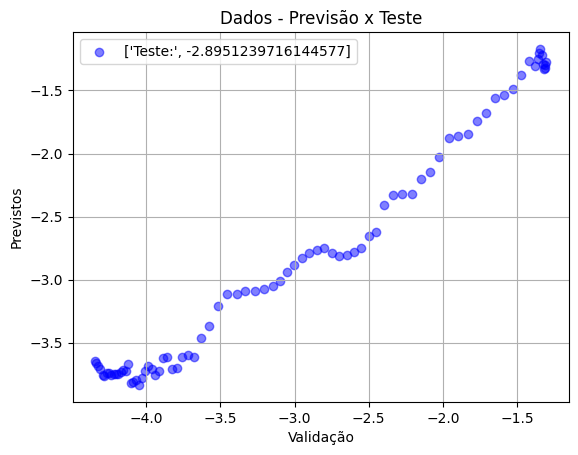

SMAPE: 6.394000699972576


In [94]:
#______________________Redes Neurais______________________________________

regressor = MLPRegressor(verbose=False, max_iter=1000, tol=0.0000001, solver='adam', shuffle=True, hidden_layer_sizes=(10), activation='identity')
regressor.fit(x_train_normalized, y_train_normalized)
score_train = regressor.score(x_train_normalized, y_train_normalized)
print('Score do Treinamento para Conjunto de Treinamento:', score_train)
#score_val = regressor.score(x_val_normalized, y_val_normalized)
#print('Score do Treinamento para Conjunto de Validação:', score_val)
previsoes = regressor.predict(x_test_normalized)

mae = mean_absolute_error(y_test_normalized, previsoes)
print('MAE:', mae)

mse = mean_squared_error(y_test_normalized, previsoes)
print('MSE:', mse)
score_test = regressor.score(x_test_normalized, y_test_normalized)
print('Score do Teste:', score_test)


fig, ax = plt.subplots()
plt.title('Dados - Previsão x Teste')
plt.xlabel("Validação")
plt.ylabel("Previstos")
#------ Plota: alterando os indices para cada fluido dos 6 poços -----#
qo_test = y_test_normalized.iloc[:,0]
saida = pd.DataFrame(regressor.predict(x_test_normalized))
qo_pred_test = saida.iloc[:,0]
ax.scatter(qo_test, qo_pred_test, color='blue', label= ['Teste:',score_test], alpha=0.5)
#ax.scatter(y_test_normalized, regressor.predict(x_test_normalized), color='blue', label= ['Teste',score_test], alpha=0.5)
ax.legend()
ax.grid(True)
plt.show()

smape = smape_calc(qo_test, qo_pred_test)
print('SMAPE:', smape)

## Plota Gráficos de Dispersão

### Conjunto de Treinamento

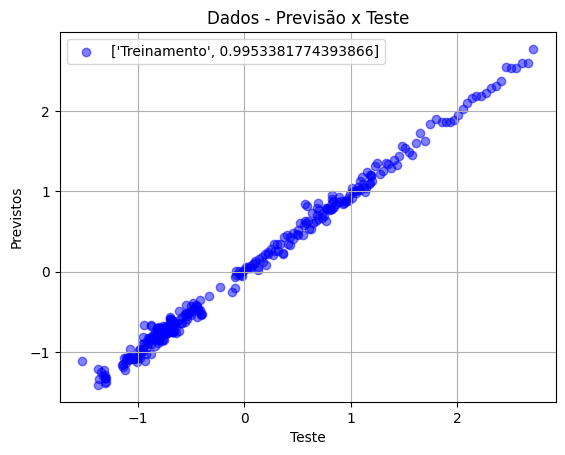

In [80]:
fig, ax = plt.subplots()
plt.title('Dados - Previsão x Teste')
plt.xlabel("Teste")
plt.ylabel("Previstos")
#------ Plota: alterando os indices para cada fluido dos 6 poços -----#
qo_train = y_train_normalized.iloc[:,0]
saida = pd.DataFrame(regressor.predict(x_train_normalized))
qo_pred_train = saida.iloc[:,0]
ax.scatter(qo_train, qo_pred_train, color='blue', label= ['Treinamento',score_train], alpha=0.5)
#ax.scatter(y_train_normalized, regressor.predict(x_train_normalized), color='blue', label= ['Treinamento',score_train], alpha=0.5)
ax.legend()
ax.grid(True)
plt.show()

### Conjunto de Teste

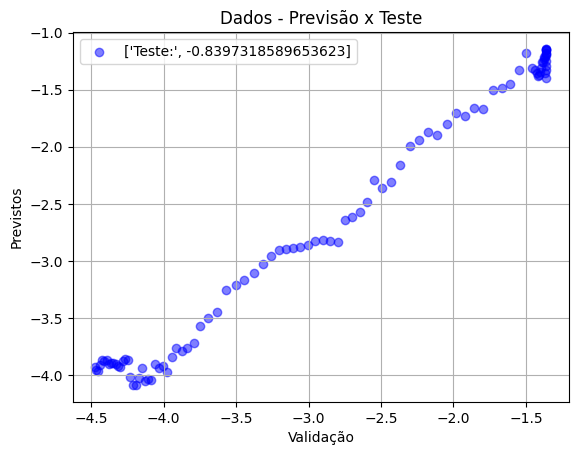

In [81]:
fig, ax = plt.subplots()
plt.title('Dados - Previsão x Teste')
plt.xlabel("Validação")
plt.ylabel("Previstos")
#------ Plota: alterando os indices para cada fluido dos 6 poços -----#
qo_test = y_test_normalized.iloc[:,0]
saida = pd.DataFrame(regressor.predict(x_test_normalized))
qo_pred_test = saida.iloc[:,0]
ax.scatter(qo_test, qo_pred_test, color='blue', label= ['Teste:',score_test], alpha=0.5)
#ax.scatter(y_test_normalized, regressor.predict(x_test_normalized), color='blue', label= ['Teste',score_test], alpha=0.5)
ax.legend()
ax.grid(True)
plt.show()

# Modelo de Ridge Regression

Score da base de Treinamento para regressão linear:  0.999908629358599
Coeficientes da regressão linear multipla:  [[-4.19961918e-03  2.71110299e-03 -3.24177856e-03 ...  6.92688478e-03
   1.38999370e-02  4.71194841e-03]
 [-5.60100470e-04  7.21529365e-03  4.24868697e-03 ...  6.00316519e-03
  -5.31381312e-03  7.54899801e-03]
 [ 1.86603846e-03  3.64371310e-03  2.76515529e-03 ...  3.33100685e-04
  -2.22159085e-04  8.18065332e-05]
 ...
 [-1.10045017e-03 -7.07200394e-04 -1.17914732e-03 ...  3.51129057e-03
   4.18321098e-03  2.01358852e-03]
 [ 1.59477439e-02  4.08336250e-03  1.17957342e-02 ...  4.15142932e-03
   4.39250058e-03 -1.33824207e-02]
 [-1.93683059e-03 -5.09716199e-03 -2.26002664e-03 ...  2.72667561e-03
   2.04958045e-03 -4.84287559e-04]]
MAE: 0.33520060385815814
MSE: 0.22166269436937877
Score do Teste -4.418149614952556


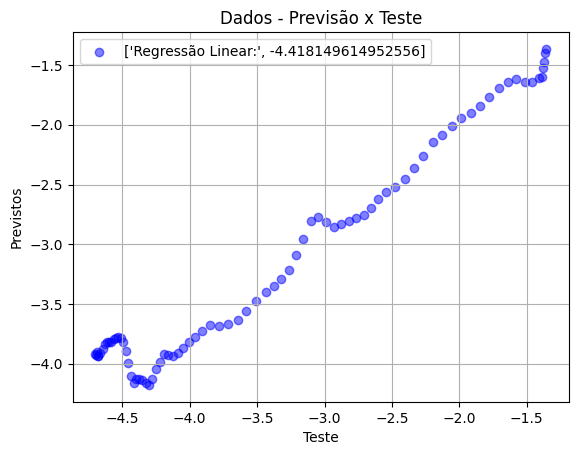

SMAPE: 6.8086592504796775


In [17]:
#______________________Ridge Regression_______________________________________

regressor = Ridge(alpha=0.4, fit_intercept=True)
regressor.fit(x_train_normalized, y_train_normalized)
# Avaliação do treinamento
score = regressor.score(x_train_normalized, y_train_normalized)
#Return the coefficient of determination R^2 of the prediction.
print('Score da base de Treinamento para regressão linear: ', score)
previsoes = regressor.predict(x_test_normalized)
coeficientes = regressor.coef_
print("Coeficientes da regressão linear multipla: ",coeficientes)

mae = mean_absolute_error(y_test_normalized, previsoes)
print('MAE:', mae)

mse = mean_squared_error(y_test_normalized, previsoes)
print('MSE:', mse)
score_t = regressor.score(x_test_normalized, y_test_normalized)
print('Score do Teste', score_t)

fig, ax = plt.subplots()
plt.title('Dados - Previsão x Teste')
plt.xlabel("Teste")
plt.ylabel("Previstos")
#------ Plota: alterando os indices para cada fluido dos 6 poços -----#
qo_test = y_test_normalized.iloc[:,0]
saida = pd.DataFrame(previsoes)
qo_pred_test = saida.iloc[:,0]
ax.scatter(qo_test, qo_pred_test, color='blue', label= ['Regressão Linear:',score_t], alpha=0.5)
#ax.scatter(y_test_normalized, regressor.predict(x_test_normalized), color='red', label=['Regressão Linear:', score_t], alpha=0.1)
ax.legend()
ax.grid(True)
plt.show()

smape = smape_calc(qo_test, qo_pred_test)
print('SMAPE:', smape)

# Modelo Lasso Linear Regression

Score da base de Treinamento para regressão linear:  0.9988132012643547
Coeficientes da regressão linear multipla:  [[ 0.          0.         -0.         ...  0.00089965  0.
   0.        ]
 [ 0.          0.          0.02984108 ...  0.         -0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.         -0.         -0.         ...  0.          0.00294643
   0.        ]
 [-0.         -0.         -0.         ... -0.          0.00281225
  -0.        ]
 [-0.         -0.         -0.         ...  0.          0.00119698
  -0.        ]]
MAE: 0.09885848829665604
MSE: 0.021249959416875536
Score do Teste 0.7754297020761189


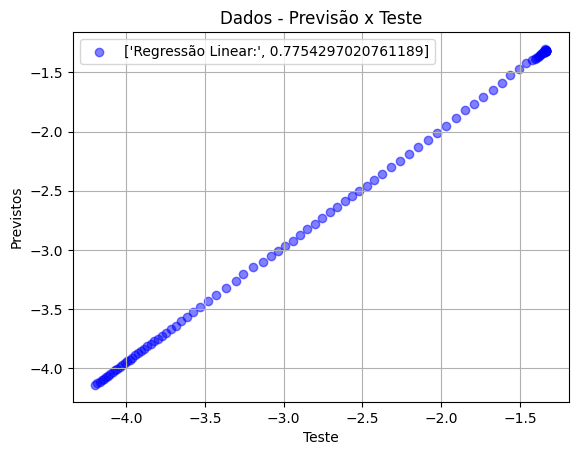

SMAPE: 1.2536332230248606


In [64]:
#______________________Regressão Linear Lasso_______________________________________

regressor = linear_model.Lasso(alpha=0.001)
#from sklearn.linear_model import HuberRegressor, LinearRegression
#regressor = HuberRegressor()
regressor.fit(x_train_normalized, y_train_normalized)
# Avaliação do treinamento
score = regressor.score(x_train_normalized, y_train_normalized)
#Return the coefficient of determination R^2 of the prediction.
print('Score da base de Treinamento para regressão linear: ', score)
previsoes = regressor.predict(x_test_normalized)
coeficientes = regressor.coef_
print("Coeficientes da regressão linear multipla: ",coeficientes)

mae = mean_absolute_error(y_test_normalized, previsoes)
print('MAE:', mae)

mse = mean_squared_error(y_test_normalized, previsoes)
print('MSE:', mse)
score_t = regressor.score(x_test_normalized, y_test_normalized)
print('Score do Teste', score_t)

fig, ax = plt.subplots()
plt.title('Dados - Previsão x Teste')
plt.xlabel("Teste")
plt.ylabel("Previstos")
#------ Plota: alterando os indices para cada fluido dos 6 poços -----#
qo_test = y_test_normalized.iloc[:,0]
saida = pd.DataFrame(previsoes)
qo_pred_test = saida.iloc[:,0]
ax.scatter(qo_test, qo_pred_test, color='blue', label= ['Regressão Linear:',score_t], alpha=0.5)
#ax.scatter(y_test_normalized, regressor.predict(x_test_normalized), color='red', label=['Regressão Linear:', score_t], alpha=0.1)
ax.legend()
ax.grid(True)
plt.show()

smape = smape_calc(qo_test, qo_pred_test)
print('SMAPE:', smape)

# Modelo de Regressão Linear

Score da base de Treinamento para regressão linear:  1.0
Coeficientes da regressão linear multipla:  [[-7.34733491e-01 -8.21743672e-01  1.07820462e+02 ... -1.16158764e-01
   1.67942853e-01  4.43899467e-01]
 [-2.72712960e-01  3.55785476e-01  7.02966229e+00 ... -4.98303462e-03
  -1.97757837e-02 -3.16397329e-02]
 [-1.12045331e-02  6.76609575e-02  2.40126732e+00 ...  4.94087255e-03
   2.69229785e-04 -1.40842364e-03]
 ...
 [ 8.60353924e-02 -4.11831141e-03  1.14165354e+00 ...  7.22821646e-03
  -1.42551954e-02 -9.14495606e-03]
 [ 1.26956553e-01 -4.73321115e-01  1.81863064e+00 ...  1.69358155e-02
  -3.01880201e-02 -8.16856276e-03]
 [ 3.15353522e-02  7.62804819e-03 -1.53526600e+00 ...  5.88234086e-03
   4.11201420e-03  3.36746826e-04]]
MAE: 4.1702979332579915
MSE: 120.21646225866854
Score do Teste -199.02938675710095


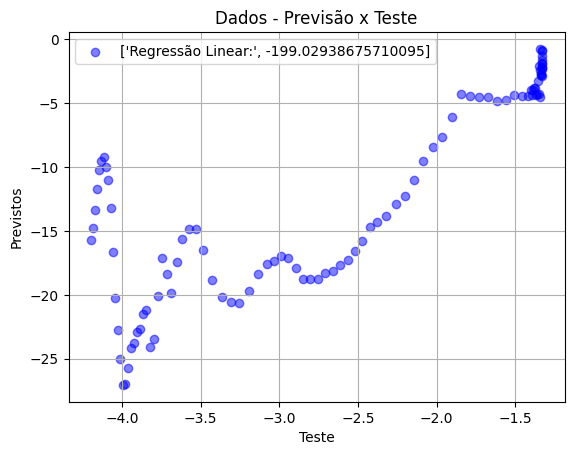

SMAPE: 111.49736500133686


In [51]:
#______________________Regressão Linear_______________________________________

regressor = LinearRegression()
regressor.fit(x_train_normalized, y_train_normalized)
# Avaliação do treinamento
score = regressor.score(x_train_normalized, y_train_normalized)
#Return the coefficient of determination R^2 of the prediction.
print('Score da base de Treinamento para regressão linear: ', score)
previsoes = regressor.predict(x_test_normalized)
coeficientes = regressor.coef_
print("Coeficientes da regressão linear multipla: ",coeficientes)

mae = mean_absolute_error(y_test_normalized, previsoes)
print('MAE:', mae)

mse = mean_squared_error(y_test_normalized, previsoes)
print('MSE:', mse)
score_t = regressor.score(x_test_normalized, y_test_normalized)
print('Score do Teste', score_t)

fig, ax = plt.subplots()
plt.title('Dados - Previsão x Teste')
plt.xlabel("Teste")
plt.ylabel("Previstos")
#------ Plota: alterando os indices para cada fluido dos 6 poços -----#
qo_test = y_test_normalized.iloc[:,0]
saida = pd.DataFrame(previsoes)
qo_pred_test = saida.iloc[:,0]
ax.scatter(qo_test, qo_pred_test, color='blue', label= ['Regressão Linear:',score_t], alpha=0.5)
#ax.scatter(y_test_normalized, regressor.predict(x_test_normalized), color='red', label=['Regressão Linear:', score_t], alpha=0.1)
ax.legend()
ax.grid(True)
plt.show()

smape = smape_calc(qo_test, qo_pred_test)
print('SMAPE:', smape)

In [ ]:
#from sklearn.metrics import r2_score
#for i in range(1,19):
#  r2 = r2_score(y_test_normalized[(299+i)], previsoes[:,(i-1)])
#  print(r2)

#from sklearn.metrics import mean_absolute_error
#for i in range(1,19):
#  mae = mean_absolute_error(y_test_normalized[(149+i)], previsoes[:,(i-1)])
#  print(mae)

#from sklearn.metrics import mean_squared_error
for i in range(1,19):
  mse = mean_squared_error(y_test_normalized[(149+i)], previsoes[:,(i-1)])
  print(mse)

# Modelo LSTM

In [ ]:
#x_train_normalized.shape
y_train_normalized.shape

(316, 18)

In [34]:
#______________________Construindo Modelo LSTM_______________________________________

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

import tensorflow as tf
import random as python_random

def reset_seeds():
    np.random.seed(10)
    python_random.seed(10)
    tf.random.set_seed(10)

reset_seeds()

Rede_LSTM = Sequential()

Rede_LSTM.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(x_train_normalized.shape[1],1)))
Rede_LSTM.add(Dropout(0.2))

#Rede_LSTM.add(LSTM(units=50, activation='relu', return_sequences=True))
#Rede_LSTM.add(Dropout(0.3))

Rede_LSTM.add(LSTM(units=50, activation='relu'))
Rede_LSTM.add(Dropout(0.2))

Rede_LSTM.add(Dense(units=18))

Rede_LSTM.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 375, 50)           10400     
                                                                 
 dropout_4 (Dropout)         (None, 375, 50)           0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 18)                918       
                                                                 
Total params: 31518 (123.12 KB)
Trainable params: 31518 (123.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
Rede_LSTM.compile(optimizer='adam', loss='mean_squared_error')

history = Rede_LSTM.fit(x_train_normalized,y_train_normalized, epochs=4, batch_size=128, shuffle=True)

Epoch 1/4
3/3 [==============================] - 6s 719ms/step - loss: 0.9946
Epoch 2/4
3/3 [==============================] - 2s 770ms/step - loss: 0.9869
Epoch 3/4
3/3 [==============================] - 3s 761ms/step - loss: 0.9773
Epoch 4/4
3/3 [==============================] - 3s 783ms/step - loss: 0.9614


4/4 [==============================] - 1s 137ms/step
MAE: 1.5773354009249465
MSE: 2.8835518889374803


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


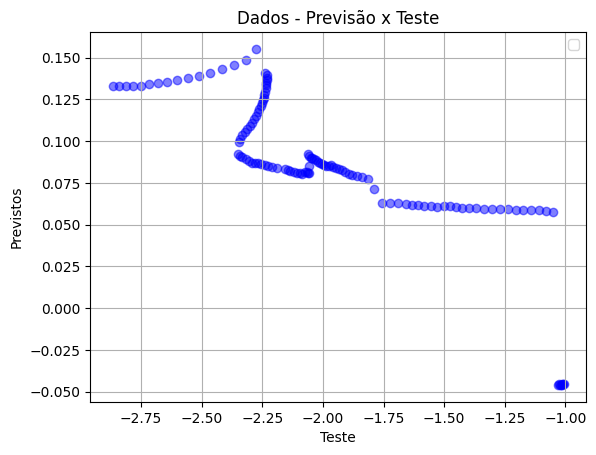

SMAPE: 198.8736586526573


In [36]:
previsoes = Rede_LSTM.predict(x_test_normalized)

mae = mean_absolute_error(y_test_normalized, previsoes)
print('MAE:', mae)

mse = mean_squared_error(y_test_normalized, previsoes)
print('MSE:', mse)

fig, ax = plt.subplots()
plt.title('Dados - Previsão x Teste')
plt.xlabel("Teste")
plt.ylabel("Previstos")
#------ Plota: alterando os indices para cada fluido dos 6 poços -----#
qo_test = y_test_normalized.iloc[:,0]
saida = pd.DataFrame(previsoes)
qo_pred_test = saida.iloc[:,0]
ax.scatter(qo_test, qo_pred_test, color='blue', alpha=0.5)
#ax.scatter(y_test_normalized, regressor.predict(x_test_normalized), color='red', label=['Regressão Linear:', score_t], alpha=0.1)
ax.legend()
ax.grid(True)
plt.show()

smape = smape_calc(qo_test, qo_pred_test)
print('SMAPE:', smape)

# Visualização dos Resultados na forma Temporal

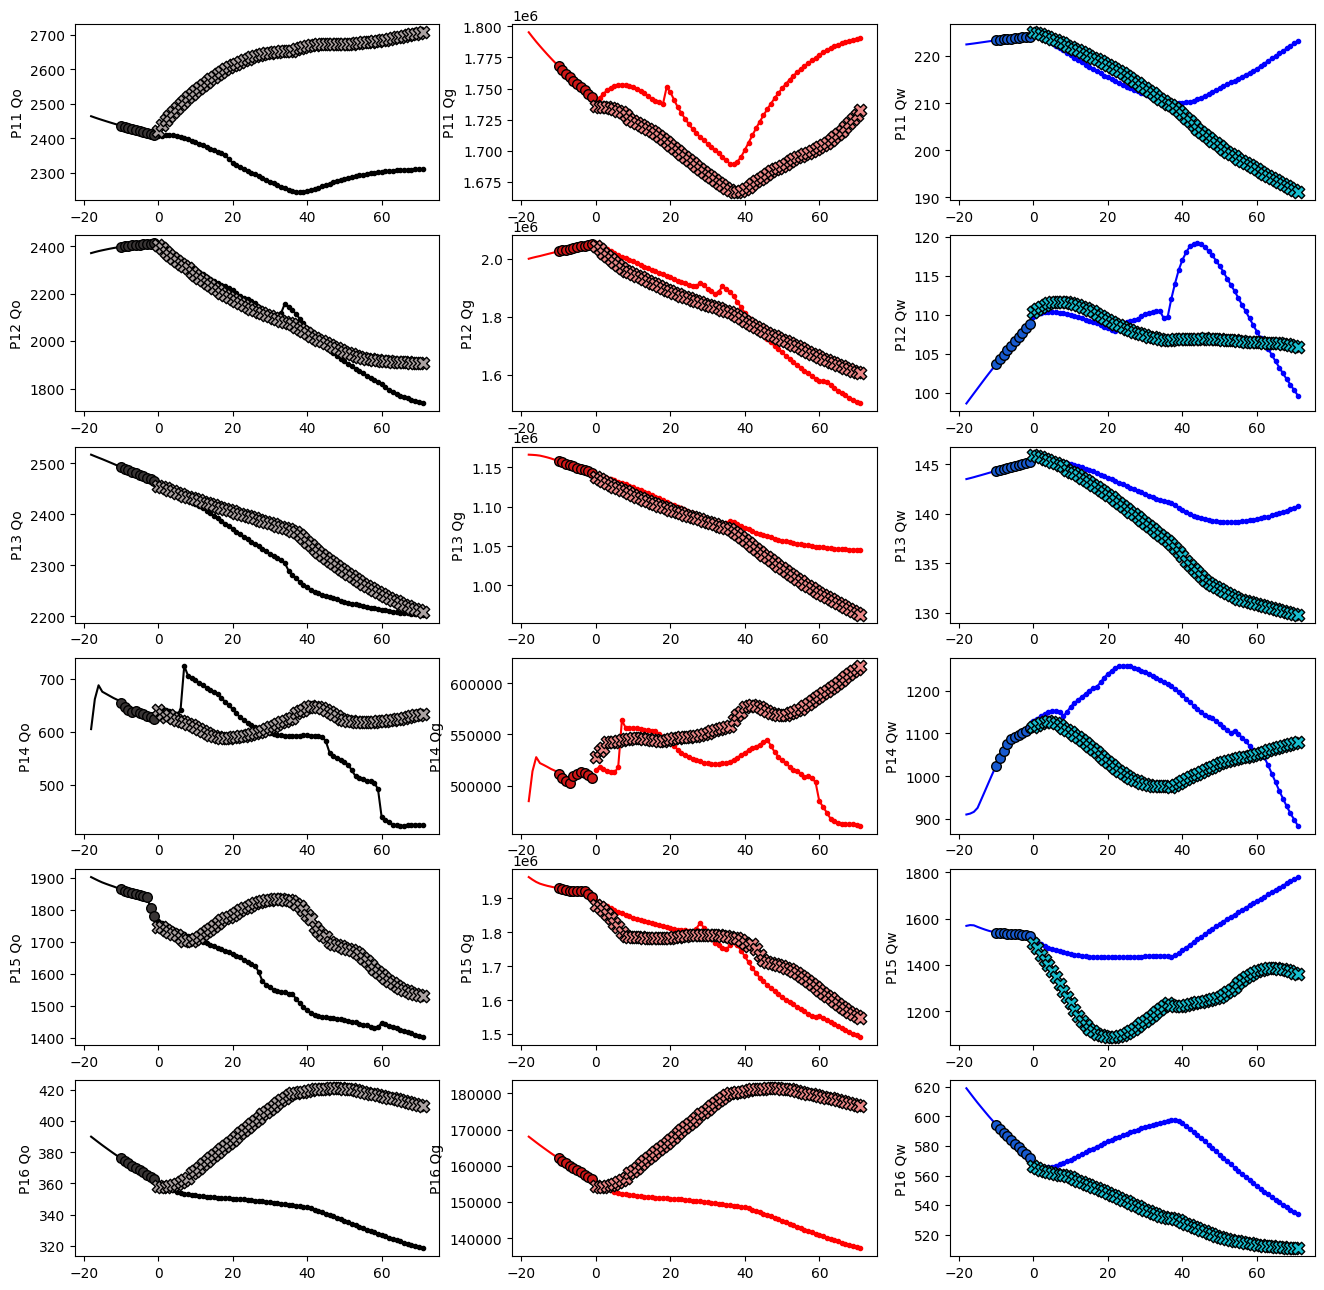

In [219]:
# Entradas de injeções futuras para serem concatenadas (necessário shift de 1 time step)
inj_schedule = x_val_normalized.values[1:,(len(x_val_normalized.columns)-7):] #últimas 7 colunas correspondem aos dados da injeção presente
# Pega apenas o primeiro time step das entradas de teste
in_timeseries = x_val_normalized[1:2].values

pred_look_forward = 72 #número de passos para repetir procedimento de previsão
y_predicted = []

for i in range(pred_look_forward):
  prev_atual = regressor.predict(in_timeseries)
  in_timeseries = np.concatenate((in_timeseries[:,25:],prev_atual,inj_schedule[i:(i+1),:]),axis=1)
  y_predicted.extend(preprocessParams_y.inverse_transform(prev_atual))

y_pred_df = pd.DataFrame(y_predicted)

plt.figure(figsize=(16, 16))
plot_col = 1

for n_pocos in range(1,7):
#n_pocos = 3
  plt.subplot(6, 3, plot_col)
  plt.ylabel(f'P1{n_pocos} Qo')
  plt.plot(range(-18, 0), y_train[(len(y_train)-18):][(len(x_val_normalized.columns)+n_pocos-1)], zorder=0, color = 'k')
  plt.plot(y_pred_df.index, y_val[:pred_look_forward][(len(x_val_normalized.columns)+n_pocos-1)], marker='.', zorder=1, color = 'k')
  plt.scatter(range(-look_back, 0), y_train[(len(y_train)-look_back):][(len(x_val_normalized.columns)+n_pocos-1)], marker='o', edgecolors='k', label='Predictions', c='#383434', s=48, zorder=2)
  plt.scatter(y_pred_df.index, y_pred_df[(n_pocos-1)], marker='X', edgecolors='k', label='Predictions', c='#aba2a2', s=80, zorder=3)
  plot_col = plot_col +1
  plt.subplot(6, 3, plot_col)
  plt.ylabel(f'P1{n_pocos} Qg')
  plt.plot(range(-18, 0), y_train[(len(y_train)-18):][(len(x_val_normalized.columns)+6+n_pocos-1)], zorder=0, color = 'r')
  plt.plot(y_pred_df.index, y_val[:pred_look_forward][(len(x_val_normalized.columns)+6+n_pocos-1)], marker='.', zorder=1, color = 'r')
  plt.scatter(range(-look_back, 0), y_train[(len(y_train)-look_back):][(len(x_val_normalized.columns)+6+n_pocos-1)], marker='o', edgecolors='k', label='Predictions', c='#cf1717', s=48, zorder=2)
  plt.scatter(y_pred_df.index, y_pred_df[(6+n_pocos-1)], marker='X', edgecolors='k', label='Predictions', c='#eb8686', s=80, zorder=3)
  plot_col = plot_col +1
  plt.subplot(6, 3, plot_col)
  plt.ylabel(f'P1{n_pocos} Qw')
  plt.plot(range(-18, 0), y_train[(len(y_train)-18):][(len(x_val_normalized.columns)+12+n_pocos-1)], zorder=0, color = 'b')
  plt.plot(y_pred_df.index, y_val[:pred_look_forward][(len(x_val_normalized.columns)+12+n_pocos-1)], marker='.', zorder=1, color = 'b')
  plt.scatter(range(-look_back, 0), y_train[(len(y_train)-look_back):][(len(x_val_normalized.columns)+12+n_pocos-1)], marker='o', edgecolors='k', label='Predictions', c='#175acf', s=48, zorder=2)
  plt.scatter(y_pred_df.index, y_pred_df[(12+n_pocos-1)], marker='X', edgecolors='k', label='Predictions', c='#17becf', s=80, zorder=3)
  plot_col = plot_col +1


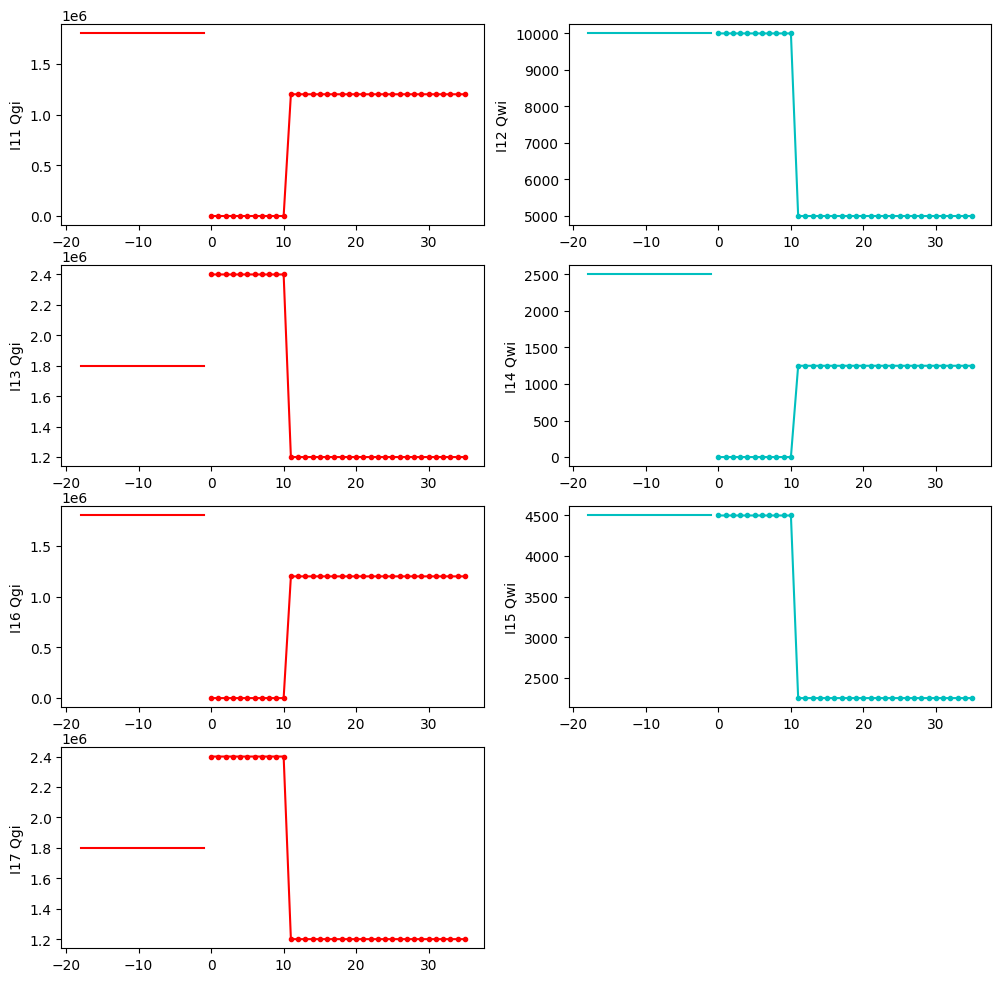

In [94]:
plt.figure(figsize=(12, 12))

plt.subplot(4, 2, 1)
plt.ylabel('I11 Qgi')
plt.plot(range(-18, 0), x_train[(len(x_train)-18):][(len(x_test_normalized.columns)-7)], zorder=0, color = 'red')
plt.plot(y_pred_df.index, x_test[:pred_look_forward][(len(x_test_normalized.columns)-7)], marker='.', zorder=1, color = 'red')

plt.subplot(4, 2, 2)
plt.ylabel('I12 Qwi')
plt.plot(range(-18, 0), x_train[(len(x_train)-18):][(len(x_test_normalized.columns)-3)], zorder=0, color = 'c')
plt.plot(y_pred_df.index, x_test[:pred_look_forward][(len(x_test_normalized.columns)-3)], marker='.', zorder=1, color = 'c')

plt.subplot(4, 2, 3)
plt.ylabel('I13 Qgi')
plt.plot(range(-18, 0), x_train[(len(x_train)-18):][(len(x_test_normalized.columns)-6)], zorder=0, color = 'red')
plt.plot(y_pred_df.index, x_test[:pred_look_forward][(len(x_test_normalized.columns)-6)], marker='.', zorder=1, color = 'red')

plt.subplot(4, 2, 4)
plt.ylabel('I14 Qwi')
plt.plot(range(-18, 0), x_train[(len(y_train)-18):][(len(x_test_normalized.columns)-2)], zorder=0, color = 'c')
plt.plot(y_pred_df.index, x_test[:pred_look_forward][(len(x_test_normalized.columns)-2)], marker='.', zorder=1, color = 'c')

plt.subplot(4, 2, 5)
plt.ylabel('I16 Qgi')
plt.plot(range(-18, 0), x_train[(len(x_train)-18):][(len(x_test_normalized.columns)-5)], zorder=0, color = 'red')
plt.plot(y_pred_df.index, x_test[:pred_look_forward][(len(x_test_normalized.columns)-5)], marker='.', zorder=1, color = 'red')

plt.subplot(4, 2, 6)
plt.ylabel('I15 Qwi')
plt.plot(range(-18, 0), x_train[(len(x_train)-18):][(len(x_test_normalized.columns)-1)], zorder=0, color = 'c')
plt.plot(y_pred_df.index, x_test[:pred_look_forward][(len(x_test_normalized.columns)-1)], marker='.', zorder=1, color = 'c')

plt.subplot(4, 2, 7)
plt.ylabel('I17 Qgi')
plt.plot(range(-18, 0), x_train[(len(x_train)-18):][(len(x_test_normalized.columns)-4)], zorder=0, color = 'red')
plt.plot(y_pred_df.index, x_test[:pred_look_forward][(len(x_test_normalized.columns)-4)], marker='.', zorder=1, color = 'red')